
# INFS7410 Week 2 Practical

##### version 1.0

###### The INFS7410 Teaching Team

##### Tutorial Etiquette:
*Please refrain from loud noises, irrelevant conversations and use of mobile phones during practical activities. Be respectful of everyone's opinions and ideas during the practical activities. You will be asked to leave if you disturb. Remember the tutor is there to help you understand and learn, not to provide debugging of your code or solutions to assignments.*


---

### About today's Practical
This week you will learn about offline evaluation methods and evaluation frameworks, set-based and rank-based evaluation measures, statistical significance testing, and visualisation. We expect that you have already installed and set-up your environment to be able to run these exercises, and if you have not, please go back to the week 1 practical notes. Evaluation, i.e. measuring the performance of a (search) system, is one of the fundamental cornerstone of Information Retrieval, because of the challenges in determining what a good system is: you should have seen this in the introductory lecture recordings for week 1.

First, put this notebook under the same directory where you stored the index (should be in the folder where prac-week1 is). Probably it is good idea to change the folder name to be something like `infs7410-pracs`, because you will put all the following weeks' practical notebook in this folder as well. 

Also, make sure you have the two indexes generated by week1 practical, namely `lucene-index-msmarco-passage-noProcessing` which is the index without any term processing, and `lucene-index-msmarco-passage-PoterStemmerStopwords` which is the index with Poter stemmer and Stopwords removal.

Alright, let's dive in the content of this week practical!

---

# Exercise 0: Interactive search with Pyserini searcher

In this exercise, you will learn how to use pyserini searcher API to search documents in our indexed collection.
At this point, you don't need to know how pyserini retrieve these documents, you will be much clearer after you learn retrieval models from week3 lecture. We just play around with it in this exercise.

First, run the following code to set up pyserini searcher, let try with our `noProcessing` index:

In [8]:
from pyserini.search import SimpleSearcher
from pyserini.analysis import Analyzer, get_lucene_analyzer

searcher = SimpleSearcher('indexes/lucene-index-msmarco-passage-noProcessing/')
searcher.set_analyzer(get_lucene_analyzer(stemming=False, stopwords=False))

The `searcher.set_analyzer` function will set which query analyzer will be used by the searcher, we set `(stemming=False, stopwords=False)` here to match the index.

The following code will issue the query to pyserini searcher and print out the first 5 documents that returned by the searcher:

In [9]:
query = 'what is information retrieval?'
hits = searcher.search(query)
for i in range(0, 5):
    print(f'{i+1} {hits[i].docid} {hits[i].raw}')

1 1404848 {
  "id" : "1404848",
  "contents" : "Information retrieval (IR) is the activity of obtaining information resources relevant to an information need from a collection of information resources. Searches can be based on full-text or other content-based indexing. Information retrieval is the science of searching for information in a document, searching for document themselves, searching for metadata that describe data and for databases such as text, image or sound. Automated information retrieval systems are used to reduce what has been called information overload."
}
2 7668955 {
  "id" : "7668955",
  "contents" : "Psychologists distinguish among three necessary stages in the learning and memory process: encoding, storage, and retrieval (Melton, 1963). Encoding is defined as initial learning of information; storage refers to maintaining information over time; retrieval is the ability to access information when you need it.he key to improving oneâs memory is to improve processes

Seems pyserini works pretty well! The first, fourth, and fifth documents are very relevant. Feel free the change the query to try out other results.

# Exercise 1: Set-base evaluation measures

In this first exercise, you will learn about set-based offline evaluation. When we talk about offline evaluation, we mean that we collected data to perform evaluation of a system outside of a production environment, i.e. the system is not live. In this case, the evaluation can be repeated an infinite amount of time, thus allowing testing different variations of the system. To perform offline evaluation, we require a set of queries, along with corresponding relevance assessments (recorded in the `.qrels` file). When executing queries to a search engine (e.g., Terrier) we store the retrieved results in the result file (`.res`) which tells us which documents were retrieved for each query, and at what rank those appeared in the results.

When we talk-about set-based evaluation, it means that we are using evaluation measures that ignore the rank of the documents (i.e., we are considering the set of documents as a whole).

In [10]:
!pip install pytrec_eval-terrier

First, we will read in the queries from the file into a list of tuples. Each pair will contain the topic id, which uniquely identifies the query, and the query itself. The topic id will be important later for evaluation, so it is important that we always keep track of this pair.

In [11]:
queries = []
with open("queries.tsv", "r") as f:
    for line in f.readlines():
        parts = line.split("\t")
        # parts[0] ~> topic id
        # parts[1] ~> query
        queries.append((parts[0], parts[1].strip()))

Now that we have all of our queries loaded, we can issue a basic retrieval. Below is a function we can re-use to create a run file using our queries.

In [12]:
def search(run_file: str, k: int=10):
    """
    If you were coding this yourself, you should use parameters for each variable,
    but in this case, we are using the queries and searcher variables from the 
    outer scope.
    """
    with open(run_file, "w") as f:
        for topic_id, query in queries: # topic id is important here.
            hits = searcher.search(query, k=k)
            for i, hit in enumerate(hits):
                # Write the results to our file.
                f.write(f"{topic_id} Q0 {hit.docid} {i} {hit.score} infs7410_w2\n")
                

def print_line(measure, scope, value):
    """
    Utility method that nicely prints out our evaluation results.
    """
    print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))                

And using this function, we can issue a search for the top 10 documents retrieved.

In [15]:
search("prac2_k10.run", k=10)

Once we have these results, we can finally get to evaluate this run. Below, we load the qrels file and the run file we just created.

In [16]:
import pytrec_eval

# Open the qrels file.
with open("qrel.txt", "r") as f:
    msmarco_qrels = pytrec_eval.parse_qrel(f)
    
# Open the run fle we created above.
with open("prac2_k10.run", "r") as f:
    prac2_k10_run = pytrec_eval.parse_run(f)

# Create an instance of an evaluator.
evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=msmarco_qrels, measures=["set"])

# Score the queries.
results = evaluator.evaluate(prac2_k10_run)

# Print out the evaluation results for this run.
# This is "per-query"; which is useful for when
# you want to know your effectiveness on a 
# fine-grained level.
for query_id, query_measures in sorted(results.items()):
    #print(query_measures)
    for measure, value in sorted(query_measures.items()):
        print_line(measure, query_id, value)
        
# The measures you are interested in here are "set_P", "set_recall", and "set_F"
# You should be able to work out which measures these correspond to based on the lecture.

num_q                    1037798 1.0000
num_rel                  1037798 13.0000
num_rel_ret              1037798 1.0000
num_ret                  1037798 10.0000
runid                    1037798 0.0000
set_F                    1037798 0.0870
set_P                    1037798 0.1000
set_map                  1037798 0.0077
set_recall               1037798 0.0769
set_relative_P           1037798 0.1000
utility                  1037798 -8.0000
num_q                    104861  1.0000
num_rel                  104861  141.0000
num_rel_ret              104861  3.0000
num_ret                  104861  10.0000
runid                    104861  0.0000
set_F                    104861  0.0397
set_P                    104861  0.3000
set_map                  104861  0.0064
set_recall               104861  0.0213
set_relative_P           104861  0.3000
utility                  104861  -4.0000
num_q                    1063750 1.0000
num_rel                  1063750 276.0000
num_rel_ret              106375

In [17]:
# But in most instances, you really are interested
# in the overall performance, usually averaged
# across all the queries.
# this snippet of code will do that.
for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in results.values()]))    

num_q                    all     43.0000
num_rel                  all     4102.0000
num_rel_ret              all     267.0000
num_ret                  all     430.0000
runid                    all     0.0000
set_F                    all     0.1915
set_P                    all     0.6209
set_map                  all     0.0952
set_recall               all     0.1389
set_relative_P           all     0.6349
utility                  all     2.4186


## Your task for this exercise

In the cell below, create another run where k=1000 and perform another round of evaluation using the set-based measures. What do you notice about the results? Why do you think you get the results you get? 

In [16]:
# TODO your solution here.                

search("prac2_k1000.run", k=1000)

with open("qrel.txt", "r") as f:
    msmarco_qrels = pytrec_eval.parse_qrel(f)
    
with open("prac2_k1000.run", "r") as f:
    prac2_k1000_run = pytrec_eval.parse_run(f)

evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=msmarco_qrels, measures=["set"])
new_results = evaluator.evaluate(prac2_k1000_run)


#query_measures = list(new_results.values())[0]



for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in new_results.values()]))    


num_q                    all     43.0000
num_rel                  all     4102.0000
num_rel_ret              all     2625.0000
num_ret                  all     43000.0000
runid                    all     0.0000
set_F                    all     0.1056
set_P                    all     0.0610
set_map                  all     0.0462
set_recall               all     0.6881
set_relative_P           all     0.6881
utility                  all     -877.9070


# Exercise 2: Rank-base evaluation measures

In the previous exercise you evaluated the run files using set-based evaluation measures. Remember: these measures do not take into consideration the rank of the documents. You will now use trec_eval to evaluate the same run files using evaluation measures that consider the rank of the documents -- we will discuss the meaning of these measures and how they are formulated in the lecture.

The rank-based measures we evaluate in this tutorial are MAP, nDCG and nDCG at various rank cut-offs. When no cut-off indication is provided, MAP and NDCG are computed across all rank positions for which a document in the .res file is indicated. When a cut-off is provided, then the corresponding measure is computed up to that rank: for example a cut-off of 10 means that the measure is computed by considering only the first 10 retrieved documents for each query.

In [17]:
evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=msmarco_qrels, measures=["map", "ndcg", "ndcg_cut"])

## Your task for this exercise

In the cell below, evaluate the two runs you have crearted using the new evaluator in the cell immediately above. Again, what do you notice between the two runs? What are the rank-based measures telling you that is different from the set-based measures?

In [18]:
# TODO your solution here.
    
results_a = evaluator.evaluate(prac2_k10_run)
query_measures = list(results_a.values())[0]

for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in results_a.values()]))
#for query_id, query_measures in sorted(results_a.items()):
#    for measure, value in sorted(query_measures.items()):
#        print_line(measure, query_id, value)

map                      all     0.1177
ndcg                     all     0.2212
ndcg_cut_10              all     0.4854
ndcg_cut_100             all     0.2308
ndcg_cut_1000            all     0.2212
ndcg_cut_15              all     0.3993
ndcg_cut_20              all     0.3513
ndcg_cut_200             all     0.2223
ndcg_cut_30              all     0.3010
ndcg_cut_5               all     0.4835
ndcg_cut_500             all     0.2212


In [19]:
results_b = evaluator.evaluate(prac2_k1000_run)
query_measures = list(results_b.values())[0]

for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in results_b.values()]))

map                      all     0.3566
ndcg                     all     0.5714
ndcg_cut_10              all     0.4854
ndcg_cut_100             all     0.4816
ndcg_cut_1000            all     0.5714
ndcg_cut_15              all     0.4771
ndcg_cut_20              all     0.4801
ndcg_cut_200             all     0.5069
ndcg_cut_30              all     0.4697
ndcg_cut_5               all     0.4835
ndcg_cut_500             all     0.5446


## Exercise 3: Statistical significance testing

Next, let us analyse further the output of the evaluation. To do this, we are going to create another run, where we have added stemming and stopwords:

In [20]:
searcher = SimpleSearcher('indexes/lucene-index-msmarco-passage-PoterStemmerStopwords')
search("prac2_k10_processed.run", k=10)
with open("prac2_k10_processed.run", "r") as f:
    prac2_k10_processed_run = pytrec_eval.parse_run(f)

Now, let's compare the results of the original, unprocessed queries that we were using in the previous two exercises, to the processed queries we just obtained results for:

In [21]:
unprocessed_results = evaluator.evaluate(prac2_k10_run)
processed_results = evaluator.evaluate(prac2_k10_processed_run)

query_measures = list(unprocessed_results.values())[0]

print("unprocessed results")
for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in unprocessed_results.values()]))  
print("----")
print("processed results")
for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in processed_results.values()]))


unprocessed results
map                      all     0.1177
ndcg                     all     0.2212
ndcg_cut_10              all     0.4854
ndcg_cut_100             all     0.2308
ndcg_cut_1000            all     0.2212
ndcg_cut_15              all     0.3993
ndcg_cut_20              all     0.3513
ndcg_cut_200             all     0.2223
ndcg_cut_30              all     0.3010
ndcg_cut_5               all     0.4835
ndcg_cut_500             all     0.2212
----
processed results
map                      all     0.1126
ndcg                     all     0.2257
ndcg_cut_10              all     0.5058
ndcg_cut_100             all     0.2363
ndcg_cut_1000            all     0.2257
ndcg_cut_15              all     0.4161
ndcg_cut_20              all     0.3653
ndcg_cut_200             all     0.2270
ndcg_cut_30              all     0.3119
ndcg_cut_5               all     0.5278
ndcg_cut_500             all     0.2257


Which results look better to you?

If you had to say if one result was better than the other with _statistical certaintly_, how would you do that? In other words, how do you know the results between these two runs aren't better or worse soley due to random chance?

Statistical analysis is performed by executing a hypothesis test to determine whether or not you can reject the null hypothesis (the hypothesis that there is no significant difference between the specified distributions). In this case, the output will be a p-value, which weighs the strength of the evidence, and is represented as a number between 0 and 1, where smaller $p$ indicates stronger evidence to reject the null hypothesis. Specifically, a p-value of $p$ means you have p% of chances to make an error in rejecting the null hypothesis (i.e. the null hypothesis is true but the analysis says it is false). In practice, $p<0.05$ and $p<0.01$ are typically used to indicate statistical significance and strong statistical significance. We will discuss more about statistical significance in this week's lecture.

In [22]:
import scipy.stats

query_ids = list(
    set(unprocessed_results.keys()) & set(processed_results.keys()))

#print(len(query_ids))

unprocessed_scores = [
    unprocessed_results[query_id]["ndcg"] for query_id in query_ids]
processed_scores = [
    processed_results[query_id]["ndcg"] for query_id in query_ids]

print(scipy.stats.ttest_rel(unprocessed_scores, processed_scores))

Ttest_relResult(statistic=-0.235809101374634, pvalue=0.8147269336127849)


The two-tailed paired student's t-test (`ttest_rel`) is the most common test you will see used to compare two rankings. If you are interested in reading why we choose to use this statistical test, please have a look at [this paper](https://dl.acm.org/doi/pdf/10.1145/1321440.1321528). 

Given the explanation of significance above, can you decide if the results are statistically significant?

## Your tasks for this exercise

1. In the cell below, perform the same statistical significance test on the unprocessed run where k=1000 and a new processed run where k=1000 (you need to make this new run file). Do you get similar results? Are these results statistically significant or not? 

In [23]:
# TODO your solution here.

search("prac2_k1000_processed.run", k=1000)
with open("prac2_k1000_processed.run", "r") as f:
    prac2_k1000_processed_run = pytrec_eval.parse_run(f)
    
unprocessed_results = evaluator.evaluate(prac2_k1000_run)
processed_results = evaluator.evaluate(prac2_k1000_processed_run)

query_measures = list(unprocessed_results.values())[0]

print("unprocessed results")
for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in unprocessed_results.values()]))
print("----")
print("processed results")
for measure in sorted(query_measures.keys()):
    print_line(measure,'all',pytrec_eval.compute_aggregated_measure(measure,
                              [query_measures[measure]for query_measures in processed_results.values()]))




unprocessed results
map                      all     0.3566
ndcg                     all     0.5714
ndcg_cut_10              all     0.4854
ndcg_cut_100             all     0.4816
ndcg_cut_1000            all     0.5714
ndcg_cut_15              all     0.4771
ndcg_cut_20              all     0.4801
ndcg_cut_200             all     0.5069
ndcg_cut_30              all     0.4697
ndcg_cut_5               all     0.4835
ndcg_cut_500             all     0.5446
----
processed results
map                      all     0.3773
ndcg                     all     0.6067
ndcg_cut_10              all     0.5058
ndcg_cut_100             all     0.5018
ndcg_cut_1000            all     0.6067
ndcg_cut_15              all     0.4980
ndcg_cut_20              all     0.4914
ndcg_cut_200             all     0.5332
ndcg_cut_30              all     0.4884
ndcg_cut_5               all     0.5278
ndcg_cut_500             all     0.5813


2. In the cell below, create a function that computes statistical significance for any evaluation measure (previously we were _only_ looking at ndcg). When you have created this function, perform the same statistical analysis in the previous cell but for each of the rank-based measures we specified, e.g., map, ndcg, ndcg_cut_5, ..., ndcg_cut_1000). Are there any results that are not statistically significant now?

In [24]:
# TODO your solution here.

unprocessed_scores = [
    unprocessed_results[query_id]["map"] for query_id in query_ids]
processed_scores = [
    processed_results[query_id]["map"] for query_id in query_ids]

print(scipy.stats.ttest_rel(unprocessed_scores, processed_scores))

unprocessed_scores = [
    unprocessed_results[query_id]["ndcg"] for query_id in query_ids]
processed_scores = [
    processed_results[query_id]["ndcg"] for query_id in query_ids]

print(scipy.stats.ttest_rel(unprocessed_scores, processed_scores))

unprocessed_scores = [
    unprocessed_results[query_id]["ndcg_cut_30"] for query_id in query_ids]
processed_scores = [
    processed_results[query_id]["ndcg_cut_30"] for query_id in query_ids]

print(scipy.stats.ttest_rel(unprocessed_scores, processed_scores))

unprocessed_scores = [
    unprocessed_results[query_id]["ndcg_cut_200"] for query_id in query_ids]
processed_scores = [
    processed_results[query_id]["ndcg_cut_200"] for query_id in query_ids]

print(scipy.stats.ttest_rel(unprocessed_scores, processed_scores))

unprocessed_scores = [
    unprocessed_results[query_id]["ndcg_cut_1000"] for query_id in query_ids]
processed_scores = [
    processed_results[query_id]["ndcg_cut_1000"] for query_id in query_ids]

print(scipy.stats.ttest_rel(unprocessed_scores, processed_scores))



Ttest_relResult(statistic=-1.2287738557652184, pvalue=0.22599722723108795)
Ttest_relResult(statistic=-1.4555595296996469, pvalue=0.15294893776147425)
Ttest_relResult(statistic=-0.7430455915357557, pvalue=0.4615902809581719)
Ttest_relResult(statistic=-1.1384235796050133, pvalue=0.26139586295098877)
Ttest_relResult(statistic=-1.4555595296996469, pvalue=0.15294893776147425)


## Exercise 4: Visualisation

Next, we will consider ways to visualise the results obtained by the four runs. The visualisation of evaluation results is important to provide further insights into the analysis of search engine effectiveness. In this exercise you will create several common plots to show the differences between queries for each run. The first plot shows the  effectiveness for each topic in terms of map:

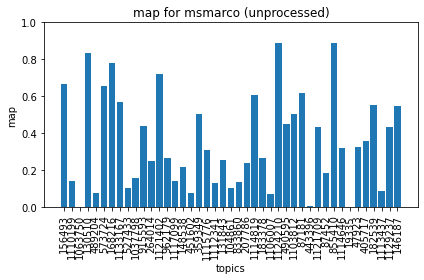

In [25]:
import matplotlib.pyplot as plt
import numpy as np

measure = "map"
title = "map for msmarco (unprocessed)"

r = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
ind = np.arange(len(r))
plt.bar(ind, list(r.values()))
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(0, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

The next plots are all about comparing two runs. The first plots both runs as above, but side-by-side.

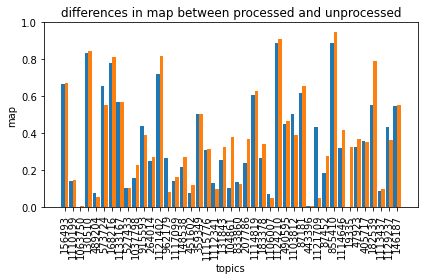

In [146]:
measure = "map"
title = "differences in map between processed and unprocessed"

r1 = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
r2 = dict([(key, value[measure]) for key, value in processed_results.items()])
ind = np.arange(len(r1))
width = 0.45
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.bar(ind - width / 2, list(r1.values()), width, label="unprocessed")
plt.bar(ind + width / 2, list(r2.values()), width, label="processed")
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(0, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

The next plot is an evolution of the above plot, where each bar is instead the difference in effectiveness between the two runs.

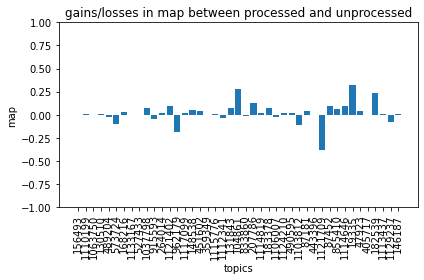

In [147]:
measure = "map"
title = "gains/losses in map between processed and unprocessed"

r1 = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
r2 = dict([(key, value[measure]) for key, value in processed_results.items()])
ind = np.arange(len(r1))
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.bar(ind, np.subtract(list(r2.values()), list(r1.values())))
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(-1, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

Finally, the last plot shows a more summative comparison of the two runs, where the effectiveness of the two runs are compared as box plots. If you are unfamiliar with box plots, the [wikipedia page](https://en.wikipedia.org/wiki/Box_plot) on this topic is a good resource.

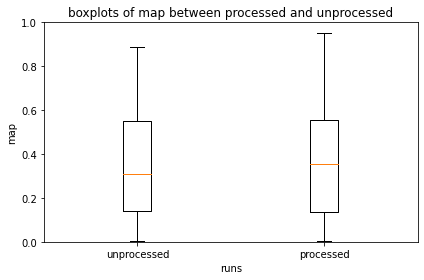

In [148]:
measure = "map"
title = "boxplots of map between processed and unprocessed"

r1 = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
r2 = dict([(key, value[measure]) for key, value in processed_results.items()])
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.boxplot([list(r1.values()), list(r2.values())])
plt.xticks([1,2], ["unprocessed", "processed"], rotation=0)
plt.ylim(-0, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("runs")
plt.tight_layout()
plt.show()

## Your task for this exercise

In the cell below, recreate the plots for the two larger runs you have now created (k=1000). You may wish to start writing these plotting routines as functions, as you will need to create _very similar_ visualisations in your project assignments.

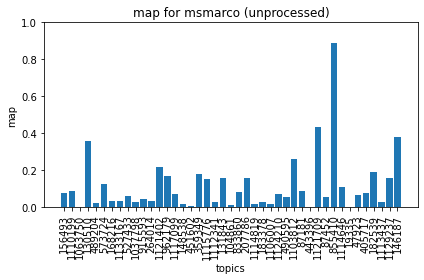

In [149]:
# TODO your solution here.

unprocessed_results = evaluator.evaluate(prac2_k10_run)
processed_results = evaluator.evaluate(prac2_k10_processed_run)

measure = "map"
title = "map for msmarco (unprocessed)"

r = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
ind = np.arange(len(r))
plt.bar(ind, list(r.values()))
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(0, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

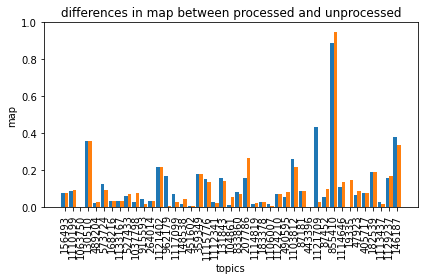

In [150]:
measure = "map"
title = "differences in map between processed and unprocessed"

r1 = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
r2 = dict([(key, value[measure]) for key, value in processed_results.items()])
ind = np.arange(len(r1))
width = 0.45
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.bar(ind - width / 2, list(r1.values()), width, label="unprocessed")
plt.bar(ind + width / 2, list(r2.values()), width, label="processed")
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(0, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

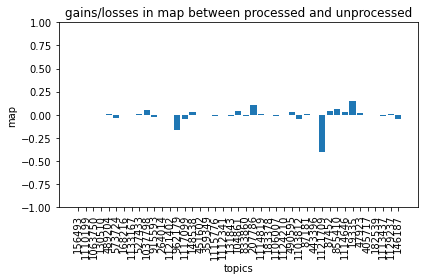

In [151]:
measure = "map"
title = "gains/losses in map between processed and unprocessed"

r1 = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
r2 = dict([(key, value[measure]) for key, value in processed_results.items()])
ind = np.arange(len(r1))
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.bar(ind, np.subtract(list(r2.values()), list(r1.values())))
plt.xticks(ind, list(r.keys()), rotation="vertical")
plt.ylim(-1, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("topics")
plt.tight_layout()
plt.show()

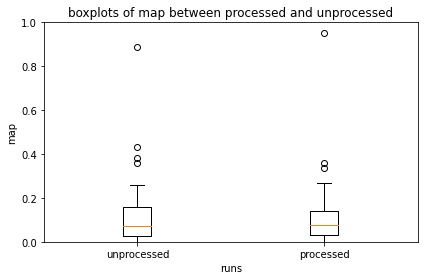

In [152]:
measure = "map"
title = "boxplots of map between processed and unprocessed"

r1 = dict([(key, value[measure]) for key, value in unprocessed_results.items()])
r2 = dict([(key, value[measure]) for key, value in processed_results.items()])
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
plt.boxplot([list(r1.values()), list(r2.values())])
plt.xticks([1,2], ["unprocessed", "processed"], rotation=0)
plt.ylim(-0, 1)
plt.title(title)
plt.ylabel(measure)
plt.xlabel("runs")
plt.tight_layout()
plt.show()